# Msc Individual Project : Dynamic Network Segmentation for Cyberdefense

The goal of this algorithm is to find the best network segmentation according a loss compromised of risk, performance, resilience and distance terms, with adjustable weights.

## Importing Libraries

In [1]:
!pip install networkx
!pip install graphillion
!pip install algorithmx
!pip install svglib
!pip install scikit-network
!pip install qdpy
!pip install deap
!pip install scikit-learn
from graphillion import GraphSet
import networkx as nx
import graphillion.tutorial as tl 
import tkinter
import matplotlib as mpl
import networkx as nx
import algorithmx
import matplotlib.pyplot as plt
import numpy as np
import copy
import random
import os
import warnings
import scipy
import math
import array
import copy
from itertools import islice
from svglib.svglib import svg2rlg
from reportlab.graphics import renderPDF, renderPM
from random import randint
from IPython.display import SVG
from sknetwork import topology
from sknetwork.visualization import svg_graph
from scipy import sparse
from IPython.display import display
from qdpy.plots import *
from qdpy import containers
from qdpy.algorithms.deap import *
from qdpy.containers import *
from qdpy.benchmarks import *
from qdpy.base import *
from deap import base
from deap import creator
from deap import tools
from deap import algorithms
from itertools import chain
from itertools import islice
from random import randint
from sklearn.neighbors import NearestNeighbors,BallTree,KDTree

## Specifying parameters

###Specify Network parameters

In [2]:
########### Number of enclaves, error rate of the IDS, number of low value devices, update rate ----------------------

N = 5 #nbr of enclaves
pe = 0.7 #error rate of network level IDS
JUNK_MACHINES_NB = 20 #pseudorandom number of low value guest machines to add in enclave (smartphones, guests,..)
pupdate = 1/90 #system update rate of each enclave
s0 = [1, 0, 0, 1, 1, 1, 0, 0, 0, 1] #baseline architecture, format specified in the report in the network encoding paragraph, let it to default if there is no baseline architecture
#s0 = [0,0,0,1,0,1,1,1,0,0,0,0,0,0,1,1,1,0,0,0,0] #default architecture of seven enclaves

###########Enclave vulnerabilities , you can specify the array of vulnerabilities here, either by sampling from the CVSS or using a custom array ----------------

def CVSS_sample():
    hist = [703,914,4880,4556,27455,23785,17054,27369,553,16185] #src : CVSS distribution https://www.cvedetails.com/cvss-score-distribution.php
    return np.random.choice(list(range(1,11)),1,p = [float(h/sum(hist)) for h in hist])[0]/10

#global_vulnerabilities = [CVSS_sample() for j in range(N)]
#global_vulnerabilities = [0,0.48,0.762,0.827,0.762]#coevolv paper for N5
global_vulnerabilities = [0,0.5,0.6,0.8,0.7]#experimental : 2 small vulnerabilities, 2 high for N5
#global_vulnerabilities = [0,0.1,0.2,0.7,0.8]
#global_vulnerabilities = [0,0.5,0.6,0.8,0.7,0.9,0.8] #2 small, 4 high for N7


##########---------------------------------------------------------
if(len(global_vulnerabilities)!=N):
  print("Warning ! The vulnerabilities array should be of length N.")
else:
  print("Done !")

if(len(s0)!=int(N*(N-1)/2)):
  print("Warning ! The baseline architecture array should be of length N(N-1)/2.")
else:
  print("Done !")  

#graph space setup
GraphSet.converters['to_graph'] = nx.from_edgelist
GraphSet.converters['to_edges'] = nx.to_edgelist
complete_n = nx.complete_graph(N)
GraphSet.set_universe(complete_n)

Done !
Done !


###Specify Constraints

In [3]:
####Specify constraints here
degree_constraints = {0:range(1,3)} #specify the range of degree for each node
edge_constraints = [] #edge constraints like [(4,6)] if you want E3 and E5 to be connected
max_nbr_edges = N*(N-1)/2 #maximum number of edges 
gs_edge_constraints = GraphSet({'include': edge_constraints})
connected_vertices =  list(range(0,N)) #list of nodes that should be accessible between each other

###Specify number of machines by types, their values their group

In [4]:
########  Number of machines, their values, and their group---------------------------------------------------

###Number of machines
nb_printers = 5
nb_printer_servers = 1
nb_employees = 20
nb_dns = 5
nb_web_servers = 10
nb_databases = 10
nb_dhcp = 1
nb_syslog = 1
nb_authentication_servers = 1
nb_email_servers = 1

##########  Specify the values of the machines---------------------------------------------------


#low values
mission_impact =  [(0.05,0.02) for i in range(nb_printers)]#printers
mission_impact += [(0.05,0.1) for i in range(nb_employees)] #employee computers

#middle values
mission_impact += [(0.1,0.2) for i in range(nb_printer_servers)] #printer servers
mission_impact += [(0.2,0.5) for i in range(nb_dns)] #DNS
mission_impact += [(0.1,0.1) for i in range(nb_dhcp)] #DHCP

#high values
mission_impact += [(10,6) for i in range(nb_web_servers)] #webservers
mission_impact += [(70, 100) for i in range(nb_databases)] #Database server
mission_impact += [(100,100) for i in range(nb_syslog)] #Syslog
mission_impact += [(100,100) for i in range(nb_authentication_servers)] #Authentication server
mission_impact += [(7,9) for i in range(nb_email_servers)] #Email server

#1 firewall in each enclave
mission_impact += [(0.3,0.3)]  #mission impact and information impact of firewall (Mth machine)

#values of low value guest devices
for i in range(JUNK_MACHINES_NB):
    mission_impact += [(0.1,0.5)]

####### Specify the different types affected in different groups---------------------------------------------

types = ["printer","printer server","employee computer","dns","web server","databases","dhcp","syslog","authentication server","email server"]
resilience_affected = ["employee computer","dns","web server","email server"]
penalty_affected = ["web server","email server","dns","databases"]
high_value = ["authentication server","syslog"]



######----------------------------------------------------------------------------------------------------

M = nb_printers + nb_printer_servers + nb_employees + nb_dns + nb_web_servers + nb_databases + nb_dhcp + nb_syslog + nb_authentication_servers + nb_email_servers
print("M = ",M, " machines")

machines_numbers = [nb_printers,nb_printer_servers,nb_employees,nb_dns,nb_web_servers,nb_databases,nb_dhcp,nb_syslog,nb_authentication_servers,nb_email_servers]
cumsum = np.cumsum(machines_numbers)
names_dico = {}
names_dico.update({i:"printer" for i in range(cumsum[0])})
names_dico.update({i:"printer server" for i in range(cumsum[0], cumsum[1])})
names_dico.update({i:"employee computer" for i in range(cumsum[1], cumsum[2])})
names_dico.update({i:"dns" for i in range(cumsum[2], cumsum[3])})
names_dico.update({i:"web server" for i in range(cumsum[3], cumsum[4])})
names_dico.update({i:"databases" for i in range(cumsum[4], cumsum[5])})
names_dico.update({i:"dhcp" for i in range(cumsum[5], cumsum[6])})
names_dico.update({i:"syslog" for i in range(cumsum[6], cumsum[7])})
names_dico.update({i:"authentication server" for i in range(cumsum[7], cumsum[8])})
names_dico.update({i:"email server" for i in range(cumsum[8], cumsum[9])})
cumsum = list(cumsum)
cumsum.insert(0,0)
print("Device are (by ID number): ", names_dico)
non_penalty_affected = list(set(types)-set(penalty_affected))

number_penalty_affected = 0
number_high_value = 0
for m,v in names_dico.items():
    if v in penalty_affected:
        number_penalty_affected += 1
    if v in high_value:
        number_high_value += 1
number_non_penalty_affected = M-number_penalty_affected


M =  55  machines
Device are (by ID number):  {0: 'printer', 1: 'printer', 2: 'printer', 3: 'printer', 4: 'printer', 5: 'printer server', 6: 'employee computer', 7: 'employee computer', 8: 'employee computer', 9: 'employee computer', 10: 'employee computer', 11: 'employee computer', 12: 'employee computer', 13: 'employee computer', 14: 'employee computer', 15: 'employee computer', 16: 'employee computer', 17: 'employee computer', 18: 'employee computer', 19: 'employee computer', 20: 'employee computer', 21: 'employee computer', 22: 'employee computer', 23: 'employee computer', 24: 'employee computer', 25: 'employee computer', 26: 'dns', 27: 'dns', 28: 'dns', 29: 'dns', 30: 'dns', 31: 'web server', 32: 'web server', 33: 'web server', 34: 'web server', 35: 'web server', 36: 'web server', 37: 'web server', 38: 'web server', 39: 'web server', 40: 'web server', 41: 'databases', 42: 'databases', 43: 'databases', 44: 'databases', 45: 'databases', 46: 'databases', 47: 'databases', 48: 'databas

###Specify Attack parameters (default parameters proposed)

In [5]:
recon_percentage = 0.7 #how much time percentage to spend on reconnaissance
times = [int(M/2)]*(N-1) #default time for the attacker to spend in each enclave
T = times[0]*(N-2) #default total simulation time
beta = 2 #attacker spread strength, shows how many machines an attacker can infiltrate in a time unit
c = 0.9 #compromise appetite
a = 0.4 #information appetite

###Specify the different threats

In [16]:
PCS = [] #List of infected PCS, put their ids, by looking at names_dico
if(len(PCS)>0):
  dynamic_threat = True #if there are pre-infected devices, we are in an internal threat environment
else:
  dynamic_threat = False

### Execute this cell to build the space of constrained graphs (KNN algorithm)

In [17]:
####### TO EXECUTE ----------------------------

#gs is the total space of constrained graphs
gs = GraphSet.graphs(vertex_groups = [connected_vertices],degree_constraints=degree_constraints,graphset=gs_edge_constraints) #gs = set of graphs with constraints
gs = gs.smaller(int(max_nbr_edges)) # number of edges < max_nbr_edges

def get_adj(topo): #vectorized sub-diagonal adjacency to adjacency matrix
    adj = np.zeros((N,N))
    index = 0
    count = N-1
    topi = 0
    for i in range(N):
        adj[i][index+1::] = topo[topi:topi+count]
        index +=1
        topi += count
        count -=1
    for i in range(N):  
        for j in range(N):
            adj[j][i] = adj[i][j]
    return adj

def get_topo(A): #returns the vectorized form of the sub-diagonal elements of the adjacency matrix
    x,y = A.shape
    res = []
    for i in range(x):
        for j in range(y):
            if (j>i):
                res.append(int(A[i][j]))
    return res

def partition(list_in,n): #initializes a pseudorando mmachine partition
    P=len(list_in)+1
    data = list_in
    np.random.shuffle(data)
    split_points = np.random.choice(P - 2, n - 1, replace=True)
    split_points.sort()
    result = np.split(data, split_points)
    return [list(x) for x in result]
    
def connected_components(adjacency):
    return sparse.csgraph.connected_components(adjacency, False, 'weak', True)[1]

def is_valid(topo): 
    adjacency = get_adj(topo)
    adjacency_without_internet = np.delete(adjacency[1:],0,axis=1)
    labels = connected_components(adjacency_without_internet)
    if(np.sum(labels)>0): #if graph not connected without the Internet, the graph is not valid
        return False
    return True

###### Builds the distance and neighbors using the KNN algorithm -------------------------

iter_obj = iter(gs) #build list of constrained graphs
g_array = []
while True:
    try:
        graph = next(iter_obj)
        adjacency = np.array(nx.to_numpy_matrix(graph, nodelist=sorted(graph.nodes())))
        topo = get_topo(adjacency)
        if(is_valid(topo)):
            g_array.append(topo) #accept only valid graphs in the graph array
    except StopIteration:
        break
        
print("There are",len(g_array),"constrained graphs")
        
neighbors_param = 5 #number of neighbors for the KNN algorithm
neigh = NearestNeighbors(n_neighbors=neighbors_param,algorithm='kd_tree',n_jobs=-1)
neigh.fit(g_array)
dist,neighbors = neigh.kneighbors(g_array,return_distance=True) #distance and neighbors used in mutation operator to find nearest neighbors to choose from them according to their distance.

There are 380 constrained graphs


##Simulation algorithm

In [18]:
#####SIMULATION#######

class enclave:
    def __init__(self,v,s,machines,adjacency):
        self.v = v
        self.sens = s
        self.valuable_machines = machines
        self.machines = {m:0 for m in machines}#0 means not infiltrated
        self.machines[M] = 0 #Mth machine represents the firewall
        self.n_to_add = random.randint(0,JUNK_MACHINES_NB)#nbr of useless machines to add
        for useless in range(M+1,M+1+self.n_to_add): #add some useless machines
            self.machines[useless] = 0
        self.compromised = False#compromised if attacker is in 
        self.next_hops = list(np.where(np.array(adjacency)==1)[0]) #indexes of connected enclaves to enclave
    def reset(self):
        self.machines = {m:0 for m in self.valuable_machines}#0 means not infiltrated
        self.machines[M] = 0 #Mth machine represents the firewall
        for useless in range(M+1,M+1+self.n_to_add): #add some useless machines
            self.machines[useless] = 0
        self.compromised = False
        


def resilience_node(indiv,node): #Measures the resilience metric when deleting a specified node


    #get topology from graph index in gs array
    topo = g_array[indiv[0]]
    
    #setup parameters
    distr = indiv[2]
    loss_resilience = 0
    A = get_adj(topo)
    G = nx.from_numpy_array(A) 
    ListOfNodes = list(range(1,N))
    deleted = [node]

    #remove node from graph
    G.remove_nodes_from(deleted)

    #update the loss with the total compromise values of the devices that were inside the removed node
    loss_resilience += sum([mission_impact[m][0] for m in distr[deleted[0]-1] if names_dico[m] in resilience_affected]) #total compromise of machines present in down node
    

    #add the compromise values of devices who are disconnected from the Internet and who are in the resilience affected group
    adj = np.array(nx.to_numpy_matrix(G, nodelist=sorted(G.nodes())))
    adj_sk = sparse.csr_matrix(adj)
    dist_matrix = sparse.csgraph.shortest_path(adj_sk,directed = False)
    d_max = np.max(dist_matrix)
    ListOfNodes.remove(deleted[0])
    for index in range(len(adj)):
        if (dist_matrix[index][0]==np.inf): #if enclaves are disconnected from the internet, update loss with total compromise
            enclave = ListOfNodes[index-1]
            loss_resilience += sum([mission_impact[m][0] for m in distr[enclave-1] if names_dico[m] in resilience_affected]) #update loss

    return loss_resilience

def resilience(ind): #Measures the total resilience metric by avereging all resilience loss when deleting one node
    return np.mean([resilience_node(ind,node) for node in range(1,N)])


def distance(s0,s): #L2 distance used between two graphs
    return np.linalg.norm(np.array(s0)-np.array(s))

def init(ind): #Initialization algorithm, ind is the segmentation encoding comprised of the graph index, sensitivities array, and machine distribution array

    loss = 0

    #add resilience loss
    loss -= r_coeff*resilience(ind) 

    if(print_loss):
        print("resilience loss = ", loss)

    #setup parameters    
    topo = g_array[ind[0]]
    sensitivities = ind[1]
    sensitivities_decoded = [0]+sensitivities #default vulnerability of the internet enclave
    distr = ind[2]
    distr_decoded = [[]] + distr #default no machines in the internet
    adj = get_adj(topo)

    #setup enclaves using the enclave class and the parameters present in the segmentation encoding 
    enclaves = [enclave(global_vulnerabilities[i],sensitivities_decoded[i],distr_decoded[i],adj[i]) for i in range(N)]
    
    adj_sk = sparse.csr_matrix(adj)
    labels = connected_components(adj_sk)
    dist_matrix = sparse.csgraph.shortest_path(adj_sk,directed = False)
    d_max = np.max(dist_matrix)

    #count number of web facing devices far from the internet
    nodes_weights = [ sum(names_dico[m] in penalty_affected for m in distr_decoded[node]) for node in range(N)]
    
    #measures the cumulated distance of high value devices from the Internet
    nodes_weights_high_value = [ sum(names_dico[m] in high_value for m in distr_decoded[node]) for node in range(N)]
    high_value_dist = sum([nodes_weights_high_value[node]*dist_matrix[node][0] for node in range(N)])

    #setup attack loss
    att = 0
    
    #dictionary containing for each enclave the infected devices specified in the PCS parameter
    dico_infected_enclave_machines = {i:[PC for PC in PCS if PC in distr_decoded[i]] for i in range(1,N) if [PC for PC in PCS if PC in distr_decoded[i]]!=[]}

    if(verbose_loss):
        print("distr = ",distr_decoded)
        print("dico_infected_enclave_machines = ",dico_infected_enclave_machines)
    

    #specify attack function parameters that simulates the spread in the network  
    if(dynamic_threat):
        if(verbose_loss):
            print("dynamic threat")
        att +=  attack(enclaves,T,times, dico_infected_enclave_machines)
        
        #reset enclaves states before trying another attack
        #for e in enclaves:
        #    e.reset()
    else:
        if(verbose_loss):
            print("static modelling")
        att +=  attack(enclaves,T,times, {})


    if(print_loss):
        print("attack term = ",att)

    #update the loss
    loss += att

    #measures the performance penalty term
    penalty_term = sum([nodes_weights[node]*dist_matrix[node][0] for node in range(N)])

    #update the loss
    loss -= penalty_coeff*penalty_term

    if(print_loss):
        print("penalty term = ",-penalty_coeff*penalty_term)

    #measures the distance term from the baseline architecture s0
    dist = distance(s0,topo)
    if(print_loss):
        print("distance from s0 with coeff = ",d_coeff*dist)

    #update loss
    loss -= d_coeff*dist
    return [loss]

def attack(enclaves,T,times,dico_enclave_machines): #the attack function simulates the spread inside the network, it takes as arguments
    # enclaves : list of enclaves
    #T : total simulation time
    # times : array specifying time to spend in each enclave
    #dico_enclave_machines : dictionarray whose keys are enclave ids and whose values are the infected devices mentioned by their ID

    #setup parameteres
    total_time = 0
    loss = 0
    internet = enclaves[0] #internet enclave
    internet.compromised = True #the internet is compromised by default
    compromised_enclaves_index = [0] #list of compromised enclave ids
    already_compromised = [0] #list of compromised enclave ids that have been compromised at least once
    


    if(dynamic_threat): #spread inside each enclave containing at least one infiltated devices by using them as starting points
        for enclave_index,dynamic_infected_machines in dico_enclave_machines.items():
            if(verbose_loss):
                print("internal enclave index = ",enclave_index)
            #set enclave as compromised
            enclave = enclaves[enclave_index]
            enclave.compromised = True
            #spread inside enclave starting from infected machines inside it
            loss += spread(enclave,times[enclave_index-1],True,dynamic_infected_machines)
            if(verbose_loss):
                print("end of internal spread : internal loss = ",loss)
            #update compromise and already compromised lists    
            already_compromised.append(enclave_index) #enclaves that have been compromised in the past
            if(enclave.compromised): #enclave can be no longer compromised after failed spread
                compromised_enclaves_index = copy.deepcopy(compromised_enclaves_index)
                #deepcopy to prevent affecting the for loop dynamically
                compromised_enclaves_index.append(enclave_index)
            
        
        #update total time spent, it is done only once after the spread because we suppose that the attacker spreads in parallel in infected enclaves
        total_time += times[enclave_index-1] 

        #stop simulation if maximum time up
        if (total_time >= T):
            if(verbose_loss):
                print("simulation finished after dynamic infections. Simulation time is up.")
            return loss
    
    
    if(verbose_loss):
        print("AFTER DYNAMIC SPREAD")


    while total_time < T:
        
        if(verbose_loss):
            print("compromised_enclaves_index = ",compromised_enclaves_index)
        

        #this for loops simulates the spreading in the network using the network model : 
        #the attacker is present in compromised enclaves and tries to spread to neighboring enclaves
        #when he tries to do so, he has to break the network level IDS and enclave vulnerability
        #if he infected enclaves that he already infected the past, he can not get additional information loss
        #he continues until the simulation time is up

        for e in compromised_enclaves_index: 
            if(verbose_loss):
              print("current_compromised_enclave = ",e)
            enclave = enclaves[e]
            if(verbose_loss):
              print("enclave.next_hops = ",enclave.next_hops)
            for next_hop_index in enclave.next_hops:
                enclave_next_hop = enclaves[next_hop_index]
                if(verbose_loss):
                  print("already compromised = ",already_compromised)
                if (next_hop_index not in compromised_enclaves_index):#dont spread to compromised enclaves.
                    if(verbose_loss):
                      print("next_hop_index_tentative = ",next_hop_index)
                    infect = random.random()
                    Network_IDS_intercept = random.random()
                    if infect < enclave_next_hop.v and Network_IDS_intercept < pe: #vuln exploited and IDS failed to block
                        if(verbose_loss):
                          print("success enclave infiltration")
                          print("next_hop_to_infect = ",next_hop_index)

                        #start the spread algorithm inside the enclave
                        #can spread to already compromised enclaves in the past, but can't get information gain
                        loss += spread(enclave_next_hop,times[next_hop_index-1],not (next_hop_index in already_compromised),[])

                        already_compromised.append(next_hop_index) #add infected enclave to already compromised list

                        if(enclave_next_hop.compromised): #enclave can be no longer compromised after failed spread
                            compromised_enclaves_index = copy.deepcopy(compromised_enclaves_index)
                            #deepcopy to prevent affecting the for loop dynamically
                            compromised_enclaves_index.append(next_hop_index)

                        #update total time
                        total_time += times[next_hop_index-1] #time to spend in enclave next_hop_index
                        if (total_time >= T):
                            if(verbose_loss):
                              print("END---------------------------------------------------------")
                            return loss
                    else:
                        if(verbose_loss):
                          print("failed enclave infiltration")
        total_time += 1
    if(verbose_loss):
      print("END---------------------------------------------------------")
    return loss
            

#enclave spread
def spread(enclave,time,info_loss_to_get,dynamic_infected_machines):#the spread algorithm simulate the attacker spread inside an enclave and uses different parameters

    #enclave is the enclave that is being infected
    #time is the time that has to be spent inside the enclave
    #info_loss_to_get is a boolean showing if the attacker can gain information loss or not
    #dynamic_infected_machines shows the different machines that are infected by the attacker and used as a starting point in the enclave (internal threat)


    if(verbose_loss):
        print("SPREAD INSIDE ENCLAVE")
        print("internal threat dynamic_infected_machines = ",dynamic_infected_machines)

    if(verbose_loss):
      print("info_loss_to_get = ",info_loss_to_get) #if enclave already compromised, no info loss to get
    enclave.compromised = True #set enclave as compromised

    #setup parameters
    loss = 0 
    recon_time = int(recon_percentage*time)  #recon time
    machines_index = list(enclave.machines.keys()) #machines in enclave
    if(verbose_loss):
        print("machines_index = ",machines_index)
    n_machines = len(machines_index) #nbr machines in enclave
    already_infected = {m:0 for m in machines_index} #machines infected at some point even if back up later after compromise
    
    #setup machine states depending on the list of already infected devices
    if(dynamic_infected_machines==[]): #static case
        if(verbose_loss):
            print("not pre-infiltrated enclave")
        first_infected = np.random.choice(machines_index,1) #list #the first machine to be infected is drawn uniformly between all machines in enclave
        enclave.machines[first_infected[0]] = 1 #machine infected
        already_infected[first_infected[0]] = 1 #machine already infected
        discovered_machines_index = [first_infected[0]] #list of discovered machines is just the first infected machine 
    else: #dynamic modelling
        if(verbose_loss):
            print("pre-infiltrated enclave")
        first_infected = copy.deepcopy(dynamic_infected_machines) #first infected machines are those specified in the dynamic_infected_machines list
        if(verbose_loss):
            print("first infected = ",first_infected)
        for machine in first_infected:
            enclave.machines[machine] = 1 #machine infected
            already_infected[machine] = 1 #machine already infected 
        discovered_machines_index = dynamic_infected_machines #list of discovered machines is the machines in the dynamic_infected_machines list
    
    #turned_down is a dictionary that, for each machine in the enclave, specifies whether it is down or not, and if yes, then it specified the
    #remaining time before getting back up
    #convert mission impact in 0,1 to back up time by multiplying it by 10
    #max so that at least 3 turns to have a machine back up
    turned_down = {m:[False,max(3,int(mission_impact[m][0]*10))] for m in machines_index}#turned down machines and their mission delay time

  
    #prior values of machines known by the attacker. 
    total_prior_values = {m:a*0.2*int(info_loss_to_get)+c*0.2 for m in machines_index} #prior values of machine, default = pessimistic (0.2,0.2)
    
    


    ######## Reconnaissance phase-----------------------------------------------------------
    if(verbose_loss):
      print("RECONNAISSANCE")
      print("recon_time = ",recon_time) 

    for t in range(recon_time):
        
        update = random.random()
        if (update < pupdate): #"pseudo probability of enclave update"
            for key in enclave.machines.keys(): #every machine in enclave no longer compromised
                enclave.machines[key] = 0
            enclave.compromised = False #enclave no longer compromised 
            if(verbose_loss):
              print("enclave update")
              print("enclave spread done") 
            return loss
        if(verbose_loss):
            print("recon...")
        not_discovered = list(set(machines_index)-set(discovered_machines_index)) #non discovered yet machines ids
        if(len(not_discovered)>0): #if there are some machines left to discover
            discovered_machine = np.random.choice(not_discovered,1)[0] #discover some pseudorandom machine
            discovered_machines_index += [discovered_machine] #add it to the discovered list
            total_prior_values[discovered_machine] = a*mission_impact[discovered_machine][1]*int(info_loss_to_get)+c*mission_impact[discovered_machine][0] #update prior values with discoverd values

    ######## Infect and Compromise among first machines-------------------------------------------------------
    #information theft and(maybe) shutting down of this first machine (its mission service)
    
    if(verbose_loss):
        print("recon done, infect first machines")
        print("first machine to infect : ",first_infected)

    for machine in first_infected:
        if(verbose_loss):
            print("machine = ",machine)
        loss -= a*mission_impact[machine][1]*int(info_loss_to_get) #update information loss due to infection on first_infected machines
        
        #compromise more likely if high compromise value and compromise appetite
        compromise_pseudo_proba = (c+3*mission_impact[machine][0])/4 #put more weight on mission impact
        compromise = random.random()
        if compromise < compromise_pseudo_proba: #compromise successful
            if(verbose_loss):
                print("machine turned down : ",machine)

            turned_down[machine][0] = True #machine state goes to turned_down, machine to be back up after some time
            nbr_turned_down = len([m for m in list(turned_down.keys()) if turned_down[m][0]])#number of turned down machines
            threshold = nbr_turned_down * enclave.sens #sensitivity threshold
            if random.uniform(0,n_machines)<threshold: #when turned down treshold reached : enclave cleansing 
                if(verbose_loss):
                    print("IDS triggered an enclave cleansing due to many down machines")
                for key in enclave.machines.keys(): #every machine in enclave no longer compromised
                    enclave.machines[key] = 0
                enclave.compromised = False #enclave no longer compromised
                loss -= sum([mission_impact[m][0] for m in machines_index])/2 # update loss with half of compromise values for all machines 
                return loss 
            else: #enclave IDS did not trigger an enclave cleansing
                loss -= c*mission_impact[machine][0] #update compromise loss
                
    
    if(verbose_loss):
        print("spread among first machines done")

    #NOT SURE ABOUT THIS---------------------
    #if(len(machines_index)==len(first_infected)): #no more machines to infect ... can the attack know that ?
        #print("loss = ",loss)
        #print("spread done, only one machine, nothing to do")
     #   return loss
    #---------------------------------------------
    
    ######Spreading phase among other machines--------------------------------------------------------
    
    for t in range(recon_time,time):
        
        update = random.random()
        if (update < pupdate): #"pseudo probability of enclave update"
            for key in enclave.machines.keys(): #every machine in enclave no longer compromised
                enclave.machines[key] = 0
            enclave.compromised = False
            if(verbose_loss):
              print("enclave update")
              print("enclave spread done") 
            return loss
        
        #get machine back up a few turns after being turned down. Tf attacker no longer has a foothold, he is kicked out.
        for m,v in turned_down.items(): #for all machines
                if v[0]: #if machine is down
                    turned_down[m][1] -=1 #decrement remaining time for back
                    if turned_down[m][1] == 0: #if remaining time for back up is up
                        if(verbose_loss):
                          print("machine back up : ",m)
                        turned_down[m][0] = False #machine no longer turned down
                        turned_down[m][1] = mission_impact[m][0] #update remaining time for backup to full time
                        enclave.machines[m] = 0 #machine no longer infected
                        if(len([m for m in list(enclave.machines.keys()) if enclave.machines[m] == 1]) == 0): #if no more infiltrated machines in the enclave, the attacker is kicked out
                            enclave.compromised = False #enclave no longer compromised
                            if(verbose_loss):
                              print("enclave spread done, no more foothold in enclave")
                            return loss
        if(verbose_loss):                
          print("spreadingggg")
          print("discovered_machines_index = ",discovered_machines_index)
          print("total_prior_values = ",total_prior_values)

        #candidate attacker targets are those that have not yet been infected
        candidate_values = {m:total_prior_values[m] for m in list(enclave.machines.keys()) if already_infected[m]==0} 
        if(verbose_loss):
          print("attacker candidate_values = ",candidate_values)

        #The attacker chooses which machines to infect by sorting candidates values to get the "beta" best machines with respect to their weighted values
        nbr_to_infect = min(beta,len(list(candidate_values.keys()))) #number of targets, depends on the beta parameter expressing the strength of the attacker
        to_infect = dict(sorted(candidate_values.items(), key=lambda x: x[1], reverse=True)[:nbr_to_infect])
        if(verbose_loss):
            print("to_infect next attacker targets = ",to_infect)
        
        #try to spread to to_infect
        IDS_ALERT = 0 #enclave level IDS alert level
        for machine_to_infect,value in to_infect.items():
            if(verbose_loss):
                print("machine_to_infect = ",machine_to_infect)
            Enclave_IDS_intercept = random.random() #attacker tries to spread to the machine
            if Enclave_IDS_intercept < pe: #Infection succeeded. The device level IDS with "probability of error pe" failed to block 
                if(verbose_loss):
                  print("machine infected")
                enclave.machines[machine_to_infect] = 1 #machine is infected
                already_infected[machine_to_infect] = 1 #machine is added to already infected list
                loss -= a*mission_impact[machine_to_infect][1]*int(info_loss_to_get) #update information loss

                #compromise more likely if high compromise value and compromise appetite
                compromise_pseudo_proba = (c+3*mission_impact[machine_to_infect][0])/4
                compromise = random.random()
                if compromise < compromise_pseudo_proba: #compromise successful
                    if(verbose_loss):
                      print("machine turned down")
                    turned_down[machine_to_infect][0] = True #machine turned down, machine to be back up some time
                    nbr_turned_down = len([m for m in list(turned_down.keys()) if turned_down[m][0]]) #number of turned down machines
                    threshold = nbr_turned_down * enclave.sens #enclave level IDS sensitivity threshold
                    if random.uniform(0,n_machines) < threshold: #when turned down treshold reached : enclave cleansing 
                        if(verbose_loss):
                            print("enclave cleansing due to many downed machines")
                        for key in enclave.machines.keys(): #every machine in enclave no longer compromised
                            enclave.machines[key] = 0
                        enclave.compromised = False #enclave no longer compromised
                        loss -= sum([mission_impact[m][0] for m in machines_index])/2 #update loss with sum of half compromise values for all machines in the enclave
                        if(verbose_loss):
                            print("enclave spread done")
                        return loss 
                    else:
                        loss -= c*mission_impact[machine_to_infect][0] #update compromise loss
                        
              




            else: #infiltration blocked
                if(verbose_loss):
                  print("machine infection failed")
                IDS_ALERT += 1 #raise enclave level alert level
                threshold = IDS_ALERT * enclave.sens #enclave level IDS threshold
                t = random.uniform(0,n_machines)
                if (t<threshold): #when treshold reached : enclave cleansing 

                    if(verbose_loss):
                        print("enclave cleansing due to many infiltration attempts")
                    for key in enclave.machines.keys(): #every machine in enclave no longer compromised
                        enclave.machines[key] = 0
                    enclave.compromised = False #enclave no longer compromised
                    loss -= sum([mission_impact[m][0] for m in machines_index])/2 #update loss with sum of half compromise values for all machines in the enclave
                    if(verbose_loss):
                        print("spread done")
                    return loss 
                   
    if(verbose_loss):
        print("enclave spread done")
    return loss


##Setup weights for risk, performance, resilience and distance terms.

machine distribution accross enclaves according to types is :  [['employee computer', 'email server', 'dns', 'web server', 'employee computer', 'web server', 'employee computer', 'databases', 'employee computer', 'dhcp'], ['web server', 'employee computer', 'databases', 'employee computer', 'databases', 'web server', 'printer', 'employee computer', 'dns', 'databases', 'web server', 'web server', 'employee computer', 'employee computer', 'databases', 'databases', 'printer server'], ['databases', 'printer', 'employee computer', 'web server', 'dns', 'web server', 'databases', 'employee computer', 'printer', 'dns', 'databases', 'employee computer', 'employee computer', 'web server', 'employee computer', 'employee computer', 'syslog', 'employee computer', 'web server'], ['printer', 'databases', 'printer', 'employee computer', 'employee computer', 'employee computer', 'dns', 'authentication server', 'employee computer']]
resilience loss =  -123.9375
attack term =  -823.7050000000002
penalty 

[-1147.6425000000002]

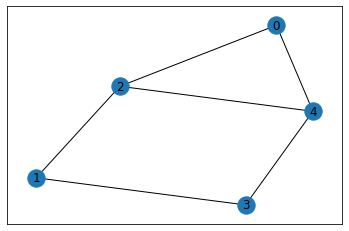

In [19]:
print_loss = True
verbose_loss = False

##### Adjust the following coefficients according to your context to see what impact they have on the total loss value
r_coeff = 5
penalty_coeff = 5
d_coeff = 0
#----------------------------------------------------------------------
def test(): #test function that initializes a pseudorandom network segmentation and prints it
    topo = random.randint(0,len(g_array)-1)
    A = get_adj(g_array[topo])
    G = nx.from_numpy_array(A) 
    nx.draw_networkx(G)
    sensitivities = list(np.random.random_sample(size = N-1)) #internet has no sensitivity
    distribution = partition(list(range(0,M)),N-1) #internet has no "machines"
    print("machine distribution accross enclaves according to types is : ",[[names_dico[m] for m in distribution[node]] for node in range(N-1)])
    return [topo,sensitivities,distribution]

indiv = test()
init(indiv)#launches one attack/defense simulation and returns the opposite of the attack, performance penalty, resilience, and distance metrics

##Optimization algorithm

###Optimization parameters

In [23]:
verbose_loss = False
print_loss = False

#### specify the types of features that you want ---------------------------------------
#  they can be : "number of links", "number of highly connected nodes","std total machine distribution",
#                "std web facing machine distritbuion","std non web facing machine distribution","cumulated dist high value machines from the Internet"

features_names = ["number of highly connected nodes","cumulated dist high value machines from the Internet"]
nb_features = len(features_names)
####### mutation parameters
eta = 20.0 #eta parameter for the sensitivity mutation, expresses the closeness to the parent sensitivity, see sensitivity mutation operator in the report
mutation_pb = 1 #probability of mutation
#### metrics weights
r_coeff = 5
penalty_coeff = 5
d_coeff = 0
##### Expected fitness domain 
fitness_domain = [(-4000, 0)]
#####
init_batch_size = 500                  # Length of initial population
batch_size = 100                       # Number of evaluations in subsequent batches
nb_iterations = 10                     # Number of iterations
max_items_per_bin = 1                  # maximum number of segmentations in each bin of the MAP-Elites grid
#####
verbose = True                         # verbose for the MAP-Elites algorithm           
show_warnings = True                   # Shows warning and error messages
log_base_path = "."
parallelismType = "multithreading"     #"multithreading" or "none" or "concurrent" or "scoop" or "multiprocessing" 
####
seed = 12                              # seed for reproducibility
np.random.seed(seed)
random.seed(seed)

###Execute this cell to run the optimization algorithm and get the best network segmentation

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


global_vulnerabilities =  [0, 0.5, 0.6, 0.8, 0.7]
dynamic_threat =  False
shares =  [27, 27, 27, 27]
infected PCS =  []
rcoeff =  5
pcoeff =  5
dcoeff =  0
S0 =  [1, 0, 0, 1, 1, 1, 0, 0, 0, 1]
T =  81
N =  5
M =  55
features =  ['number of highly connected nodes', 'cumulated dist high value machines from the Internet']
iteration	containerSize	evals	nbUpdated	avg          	std           	min         	max        	elapsed
0        	25/48        	500  	69       	[-776.884792]	[140.65866884]	[-1023.5785]	[-507.6627]	46.2642
1        	25/48        	100  	5        	[-766.155136]	[137.66042312]	[-1023.5785]	[-507.6627]	9.07199
2        	25/48        	100  	4        	[-758.78104] 	[138.22587433]	[-1023.5785]	[-507.6627]	9.18947
3        	25/48        	100  	5        	[-748.453656]	[143.00958712]	[-1023.5785]	[-507.6627]	9.03162
4        	25/48        	100  	4        	[-735.5712]  	[140.47859097]	[-1023.5785]	[-507.6627]	9.01064
5        	25/48        	100  	1        	[-733.260128]	[142.42079533

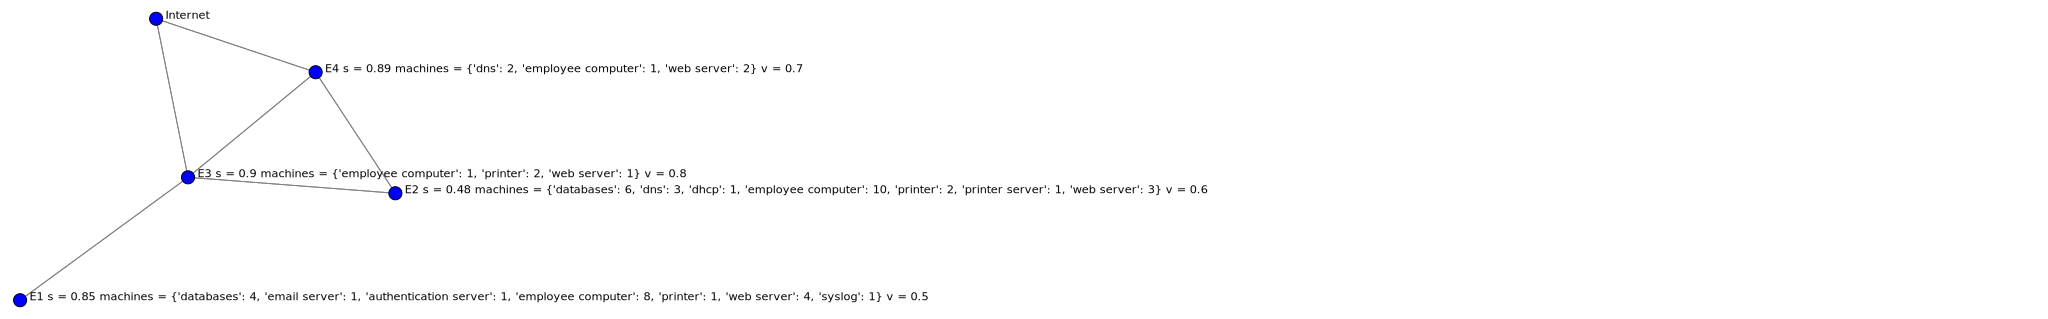

In [24]:
#OPTIMISATION

###################################


def initialize():
    topo = random.randint(0,len(g_array)-1)
    sensitivities = list(np.random.random_sample(size = N-1)) #internet has no sensitivity
    distribution = partition(list(range(0,M)),N-1) #internet has no "machines"
    return [topo,sensitivities,distribution]


def evaluate(ind):
    """Takes a segmentation as input, and returns the pair (fitness, features)"""
    topo = g_array[ind[0]] #ind[0] = index in g_array list of constrained graphs
    mat = get_adj(topo)
    score = np.mean(np.array([init(ind) for i in range(10)])).item() #score is the fitness, opposite of the loss, obtained through many simulations

    #behavior descriptors ------
    fit0 = sum(topo) #number of links
    fit1 = len([i for i in range(N) if sum(mat[i])>=3]) #nbr of enclaves that have degree >=3
    fit2 = np.std(np.array([len(l) for l in ind[2]])) #how sparse are machines
    std_perf = np.std([ sum(names_dico[m] in penalty_affected for m in ind[2][node]) for node in range(N-1)])
    std_non_perf = np.std([ sum(names_dico[m] in non_penalty_affected for m in ind[2][node]) for node in range(N-1)])
    
    #high value dist behavioral descriptor

    #measures the cumulated distance of high value devices from the Internet
    adj_sk = sparse.csr_matrix(mat)
    labels = connected_components(adj_sk)
    dist_matrix = sparse.csgraph.shortest_path(adj_sk,directed = False)
    distr_decoded = [[]]+ind[2]
    nodes_weights_high_value = [ sum(names_dico[m] in high_value for m in distr_decoded[node]) for node in range(N)]
    high_value_dist = sum([nodes_weights_high_value[node]*dist_matrix[node][0] for node in range(N)])

    #returns features according to the features_names specified by the user in the above cell---------------------------------------
    features = []
    if "number of links" in features_names:
      features += [fit0]
    if "number of highly connected nodes" in features_names:
      features += [fit1]
    if "std total machine distribution" in features_names:
      features += [fit2]
    if "std web facing machine distritbuion" in features_names:
      features += [std_perf]
    if "std non web facing machine distribution" in features_names:
      features += [std_non_perf]
    if "cumulated dist high value machines from the Internet" in features_names:
      features += [high_value_dist]

    return (score,), features
    

toolbox = base.Toolbox()
creator.create("FitnessMax", base.Fitness, weights=(1.0,))  # fitness
creator.create("Individual", list, fitness=creator.FitnessMax,features=list)
def individual(): #operator that initialize a segmentation
    return creator.Individual(initialize())

toolbox.register("individual", individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate)
toolbox.register("mutate_sens", tools.mutPolynomialBounded, low=0, up=1, eta=eta, indpb=mutation_pb) #sensitivity mutation operator

def mutate_strategy(individual): #changes in place and returns the segmentation
    
    
    #mutation of topology with KNN algo euclidian dist
    topo = copy.deepcopy(individual[0])
    index_topo = topo
    dist_topo,neighbors_topo = dist[index_topo],neighbors[index_topo] #global dist computed earlier via KNN algo
    candidates = {neighbors_topo[i]:1/dist_topo[i] for i in range(len(dist_topo)) if dist_topo[i]!=0} #weight = 1/dist => closer dist => more possibility of being selected
    new_topo_index = random.choices(list(candidates.keys()), weights=candidates.values())[0]
    new_topo = new_topo_index #new_topo is the new mutated toplogy

    #mutation of sensibilities
    mutated_sens = toolbox.mutate_sens(individual[1])
    
    #mutation of valuable machine distribution
    distr = copy.deepcopy(individual[2])
    mutated_distr = copy.deepcopy(distr)

    for i in range(len(cumsum)-1): #for each machine type
        PC = random.randint(cumsum[i],cumsum[i+1]-1) #choose a machine id
        index = [i for i in range(0,N-1) if PC in mutated_distr[i]][0] #find its corresponding index
        new_enclave = random.choice([i for i in range(N-1) if i!=index]) #find a new enclave to put it
        mutated_distr[index].remove(PC) #remove machine from its enclave
        mutated_distr[new_enclave].append(PC) #put it in another enclave
    
    individual[0] = copy.deepcopy(new_topo)
    individual[1] = copy.deepcopy(mutated_sens[0])
    individual[2] = copy.deepcopy(mutated_distr)
    return individual,
toolbox.register("mutate",mutate_strategy)
toolbox.register("select", tools.selRandom) # selection operator

###################################


print("global_vulnerabilities = ",global_vulnerabilities)
print("dynamic_threat = ",dynamic_threat)
print("shares = ",times)
print("infected PCS = ",PCS)
print("rcoeff = ",r_coeff)
print("pcoeff = ",penalty_coeff)
print("dcoeff = ",d_coeff)
print("S0 = ",s0)
print("T = ",T)
print("N = ",N)
print("M = ",M)
print("features = ", features_names)
# Algorithm parameters

nb_features = len(features_names)   # Number of features


list_max_var = [M]+[0]*(N-2)
sigma_max= np.std(list_max_var)

sigma_max_var_perf =np.std( [number_penalty_affected]+[0]*(N-2))
sigma_max_var_non_perf =np.std( [number_non_penalty_affected]+[0]*(N-2))

nb_bins,features_domain = [],[]

if "number of links" in features_names:
  nb_bins += [N*(N-1)/2-(N-1)+1]
  features_domain += [(N-1,int(N*(N-1)/2))]
if "number of highly connected nodes" in features_names:
  nb_bins += [N+1]
  features_domain += [(0,N)]
if "std total machine distribution" in features_names:
  nb_bins += [100]
  features_domain += [(0,sigma_max)]
if "std web facing machine distritbuion" in features_names:
  nb_bins += [100]
  features_domain += [(0,sigma_max_var_perf)]
if "std non web facing machine distribution" in features_names:
  nb_bins += [100]
  features_domain += [(0,sigma_max_var_non_perf)]
if "cumulated dist high value machines from the Internet" in features_names:
  nb_bins += [(N-1)*number_high_value]
  features_domain += [(number_high_value, number_high_value*(N-1) )]




# Dictionary storing parameters information
results_infos = {}
results_infos['features_domain'] = features_domain
results_infos['fitness_domain'] = fitness_domain
results_infos['nb_bins'] = nb_bins
results_infos['init_batch_size'] = init_batch_size
results_infos['nb_iterations'] = nb_iterations
results_infos['batch_size'] = batch_size
results_infos['mutation_pb'] = mutation_pb
results_infos['eta'] = eta

grid = containers.Grid(shape=nb_bins, max_items_per_bin=max_items_per_bin, fitness_domain=fitness_domain, features_domain=features_domain,storage_type=list)

with ParallelismManager(parallelismType,toolbox=toolbox) as pMgr:
    algo = DEAPQDAlgorithm(pMgr.toolbox, grid, init_batch_size = init_batch_size, batch_size = batch_size, niter = nb_iterations, 
                           mutpb = mutation_pb,
            verbose = verbose, show_warnings = show_warnings, results_infos = results_infos, log_base_path = log_base_path)
    algo.run()


# Print results info
print("Total elapsed: ",algo.total_elapsed)
#print(grid.summary())
print("#########################################################")
print("QD score = ",grid.qd_score())
print(grid.best)

title = "N"+str(N)+"T"+str(T)+"r"+str(r_coeff)+"p"+str(penalty_coeff)+"init_batch"+str(init_batch_size)+"batch"+str(batch_size)+"iter"+str(nb_iterations)+"dynamic_threat"+str(dynamic_threat)

#display and save best network segmentation-------------------------------------

best = grid.best
topo = g_array[best[0]]
sens = best[1]
nb_machines = [len(b) for b in best[2]]
distr_machines_list = best[2]

adjacency = get_adj(topo)
adj = sparse.csr_matrix(adjacency)
labels = connected_components(adj)
machines_infected_enclaves = [0 for i in range(N)]
machines_uninfected_enclaves = [0 for i in range(N)]
for i in range(1,N):
    l_infected = [names_dico[machine] for machine in distr_machines_list[i-1] if machine in PCS]
    l_uninfected = [names_dico[machine] for machine in distr_machines_list[i-1] if machine not in PCS]
    machines_infected_enclaves[i] = dict((x,l_infected.count(x)) for x in set(l_infected))
    machines_uninfected_enclaves[i] = dict((x,l_uninfected.count(x)) for x in set(l_uninfected))

if(dynamic_threat):
  names = ["Internet"]+["E"+str(i)+" s = "+str(round(sens[i-1],2))+" infected = "+ str(machines_infected_enclaves[i]) + " uninfected = "+ str(machines_uninfected_enclaves[i]) + " v = "+str(global_vulnerabilities[i]) for i in range(1,N)]
else:
  names = ["Internet"]+["E"+str(i)+" s = "+str(round(sens[i-1],2)) + " machines = "+ str(machines_uninfected_enclaves[i]) + " v = "+str(global_vulnerabilities[i]) for i in range(1,N)]
image = svg_graph(adj,labels=labels,names=names)
x=SVG(image)
display(x)
with open(title+".svg", 'w') as f:
            f.write(image)
drawing = svg2rlg(title+".svg")
renderPM.drawToFile(drawing, title+".png", fmt="PNG")



###Print the best network segmentation

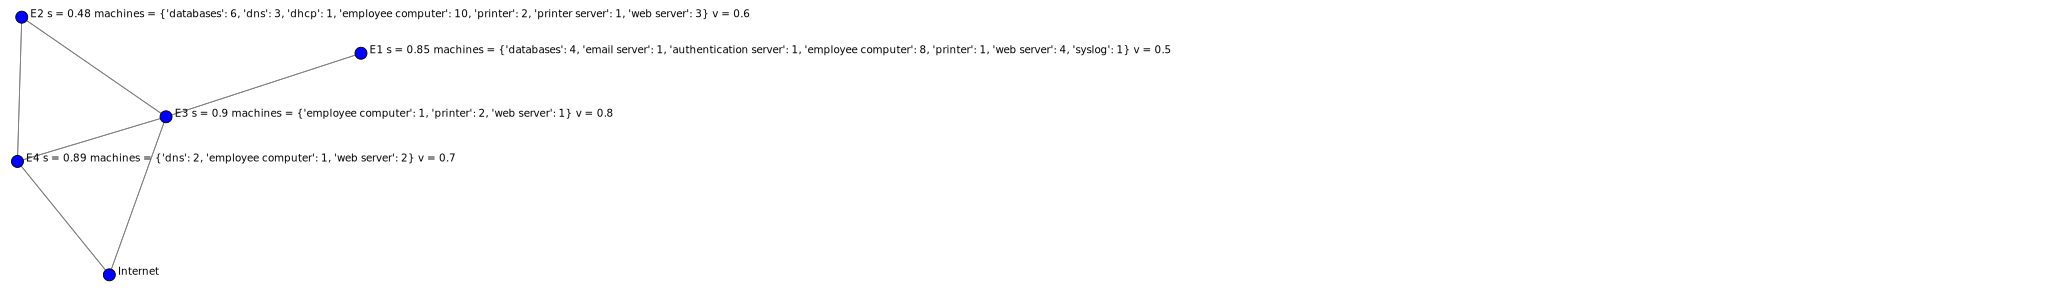

In [25]:
best = grid.best
topo = g_array[best[0]]
sens = best[1]
nb_machines = [len(b) for b in best[2]]
distr_machines_list = best[2]
adjacency = get_adj(topo)
adj = sparse.csr_matrix(adjacency)
labels = connected_components(adj)

machines_infected_enclaves = [0 for i in range(N)]
machines_uninfected_enclaves = [0 for i in range(N)]
for i in range(1,N):
    l_infected = [names_dico[machine] for machine in distr_machines_list[i-1] if machine in PCS]
    l_uninfected = [names_dico[machine] for machine in distr_machines_list[i-1] if machine not in PCS]
    machines_infected_enclaves[i] = dict((x,l_infected.count(x)) for x in set(l_infected))
    machines_uninfected_enclaves[i] = dict((x,l_uninfected.count(x)) for x in set(l_uninfected))
    
if(dynamic_threat):
  names = ["Internet"]+["E"+str(i)+" s = "+str(round(sens[i-1],2))+" infected = "+ str(machines_infected_enclaves[i]) + " uninfected = "+ str(machines_uninfected_enclaves[i]) + " v = "+str(global_vulnerabilities[i]) for i in range(1,N)]
else:
  names = ["Internet"]+["E"+str(i)+" s = "+str(round(sens[i-1],2)) + " machines = "+ str(machines_uninfected_enclaves[i]) + " v = "+str(global_vulnerabilities[i]) for i in range(1,N)]

image = svg_graph(adj,labels=labels,names=names)
x=SVG(image)
display(x)
with open(title+".svg", 'w') as f:
            f.write(image)
drawing = svg2rlg(title+".svg")
renderPM.drawToFile(drawing, title+".png", fmt="PNG")

###MAP-Elites final iteration grid


Performance grid saved in '/content/performances_gridN5T81r5p5init_batch500batch100iter10dyanmic_threatFalse.pdf'.
Results stored in the 'final.p' pickle file.


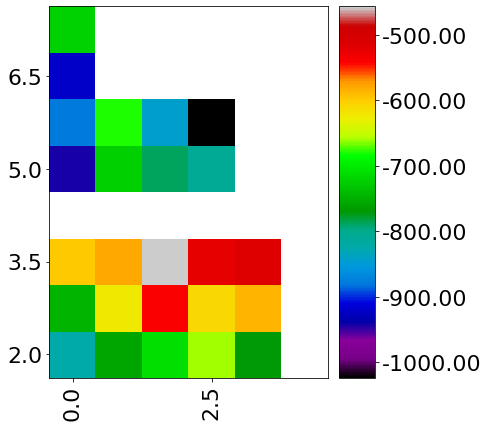

In [26]:
title = "N"+str(N)+"T"+str(T)+"r"+str(r_coeff)+"p"+str(penalty_coeff)+"init_batch"+str(init_batch_size)+"batch"+str(batch_size)+"iter"+str(nb_iterations)+"dyanmic_threat"+str(dynamic_threat)

plot_path = os.path.join(log_base_path, "performances_grid"+title+".pdf")
plotGridSubplots(grid.quality_array[... ,0], plot_path, plt.get_cmap("nipy_spectral"), grid.features_domain, grid.fitness_extrema[0], nbTicks=None)
print("\nPerformance grid saved in '%s'." % os.path.abspath(plot_path))


print("Results stored in the '%s' pickle file." % algo.final_filename)